In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load new batch and concat with initial data
batch_1 = pd.read_csv('../../data/batch1_albayrak_labels.csv')
batch_2 = pd.read_csv('../../data/batch2_albayrak_labels.csv')
batch_3 = pd.read_csv('../../data/batch3_albayrak_labels.csv')
batch_4 = pd.read_csv('../../data/batch4_albayrak_labels.csv')
initial_molluscs_data = pd.read_csv('../../data/initial_molluscs_data.csv')
molluscs_df = pd.concat([initial_molluscs_data, batch_1, batch_2, batch_3, batch_4])

molluscs_df

,Sex,Length,Width,Height,Weight,Non_Shell Weight,Intestine Weight,Shell Weight,Stage of Life
0,F,0.450000,0.345000,0.120000,0.416500,0.165500,0.095000,0.135000,Adult
1,F,0.475000,0.380000,0.145000,0.570000,0.167000,0.118000,0.187000,Adole
2,M,0.610000,0.485000,0.170000,1.022500,0.419000,0.240500,0.360000,Adult
3,I,0.430000,0.340000,0.105000,0.440500,0.238500,0.074500,0.107500,Adole
4,M,0.205000,0.155000,0.045000,0.042500,0.017000,0.005500,0.015500,Adult
...,...,...,...,...,...,...,...,...,...
245,M,0.307768,0.450745,0.219460,0.548981,0.089501,0.263947,0.028936,Adult
246,I,0.618349,0.585690,0.212054,1.707813,0.056766,0.364757,0.325959,Adult
247,I,0.526556,0.332664,0.071608,1.380792,0.488219,0.124886,0.240674,Adult
248,F,0.566639,0.421948,0.166635,1.520568,0.263118,0.356215,0.222245,Adult


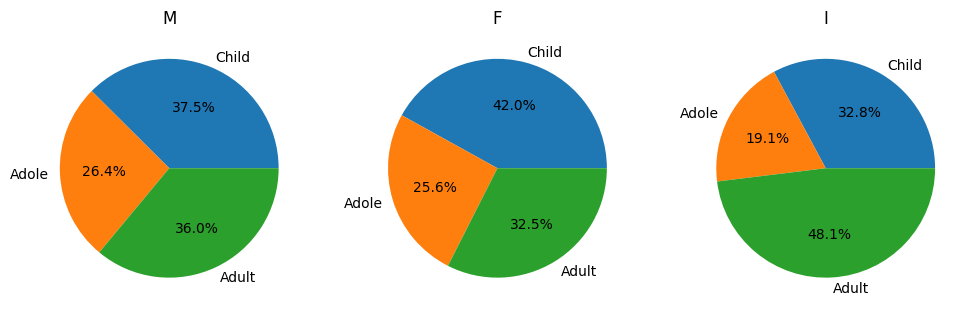

In [3]:
# Explore new data
life_stages = ['Child', 'Adole', 'Adult']
sexes = ['M', 'F', 'I']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for idx, s in enumerate(sexes):
    ratios = []
    for stage in life_stages:
        stage_ratio = len(molluscs_df[(molluscs_df['Stage of Life'] == stage) & (molluscs_df['Sex'] == s)])
        ratios.append(stage_ratio)

    # generate subplot for each sex
    axs[idx].pie(ratios, labels=life_stages, autopct='%1.1f%%')
    axs[idx].set_title(s)

fig.savefig('../../results/plots/batch2/stage_of_life_batch1.jpg')

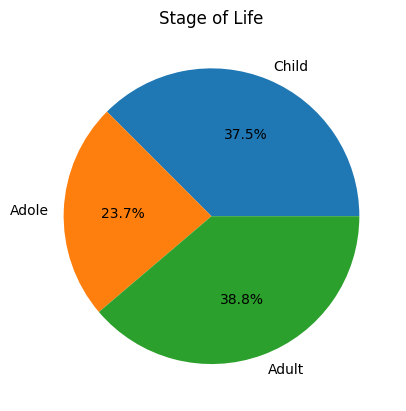

In [4]:
ratios = []
for stage in life_stages:
    ratio = len(molluscs_df[molluscs_df['Stage of Life']==stage])
    ratios.append(ratio)

plt.pie(ratios, labels=life_stages, autopct='%1.1f%%')
plt.title('Stage of Life')
plt.savefig('../../results/plots/batch2/stol.jpg')
plt.show()

mean and variance for Child: (0.26339285717218214, 0.01946799594757377)
mean and variance for Adole: (0.24652063995208756, 0.013105026069678316)
mean and variance for Adult: (0.256026639857845, 0.019008621168182683)


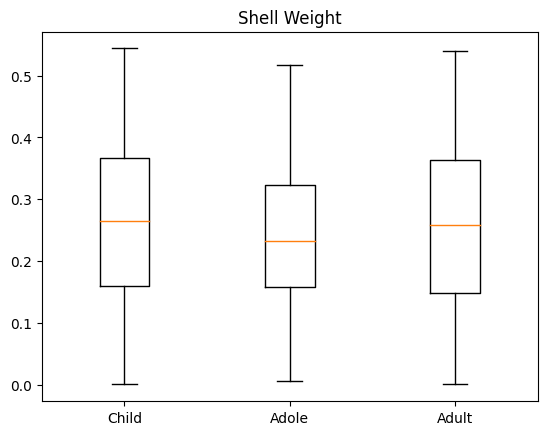

In [5]:
# Plot mean values for each sex
seq = []
feature = 'Shell Weight'

mean_var_dict = {}

for s in life_stages:
    loc_df = molluscs_df[molluscs_df['Stage of Life'] == s]
    x = loc_df[feature]
    mean_var_dict[s] = (np.mean(x), np.var(x))
    print(f'mean and variance for {s}: {mean_var_dict[s]}')
    seq.append(x)

plt.boxplot(seq, labels=life_stages)
plt.title(feature)
plt.show()

In [7]:
# Compute optimal ratio of samples
n_samples = 1016 + 250
optimal_ratio = n_samples/3
print(f'optimal ratio per class: {optimal_ratio}')

print('-----------------------')

for s in life_stages:
    loc_df = molluscs_df[molluscs_df['Stage of Life'] == s]
    print(f'current ratio {s}: {len(loc_df)}')
    print(f'needed samples: {optimal_ratio - len(loc_df)}')
    print('-----------------------')

optimal ratio per class: 422.0
-----------------------
current ratio Child: 381
needed samples: 41.0
-----------------------
current ratio Adole: 241
needed samples: 181.0
-----------------------
current ratio Adult: 394
needed samples: 28.0
-----------------------


In [7]:
from sklearn.preprocessing import LabelEncoder

# Convert nominal feature to numerical
lbl_encoder = LabelEncoder()
molluscs_df['Sex'] = lbl_encoder.fit_transform(molluscs_df['Sex'])

# Seperate X and y
X = molluscs_df.iloc[:, :8]
y = molluscs_df.iloc[:, 8]

In [8]:
from e2ml.preprocessing import StandardScaler

# Standardize each class seperately
scaler_child = StandardScaler()
scaler_adole = StandardScaler()
scaler_adult = StandardScaler()

child_df = X[y == 'Child']
scaler_child.fit(child_df)
child_df_std = scaler_child.transform(child_df)

adole_df = X[y == 'Adole']
scaler_adole.fit(adole_df)
adole_df_std = scaler_adole.transform(adole_df)

adult_df = X[y == 'Adult']
scaler_adult.fit(adult_df)
adult_df_std = scaler_adult.transform(adult_df)

# Child

In [79]:
from e2ml.experimentation import halton

n_samples_child = 23
bounds = [[-0.1, 0.1] for _ in range(8)]

# Generate 100 samples with latin hypercube
X_halton_child = halton(n_samples=n_samples_child, n_dimensions=8, bounds=bounds)

# Add design df as "noise" to the initial df
X_halton_child = child_df_std[:n_samples_child, :] + X_halton_child

# Use random discrete values for nominal feature
X_halton_child[:, 0] = np.random.choice(np.unique(child_df_std[:, 0]), size=n_samples_child)

(23, 8)

In [80]:
# Reconstruct design matrix
X_rec_child = scaler_child.inverse_transform(X_halton_child)

design_df_child = pd.DataFrame(data=X_rec_child, columns=X.columns)
design_df_child['Sex'] = design_df_child['Sex'].astype(int)

# Decode nominal features
design_df_child['Sex'] = lbl_encoder.inverse_transform(design_df_child['Sex'])

In [81]:
# Remove rows with values < 0
numerical_cols = ['Length', 'Width', 'Height', 'Weight', 'Non_Shell Weight', 'Intestine Weight', 'Shell Weight']
count = 0
for col in numerical_cols:
    design_df_child = design_df_child[design_df_child[col] >= 0]

design_df_child.shape

(23, 8)

# Adole

In [91]:
from e2ml.experimentation import halton

n_samples_adole = 205
bounds = [[-0.1, 0.1] for _ in range(8)]

# Generate 100 samples with latin hypercube
X_halton_adole = halton(n_samples=n_samples_adole, n_dimensions=8, bounds=bounds)

# Add design df as "noise" to the initial df
adole_df_std = np.concatenate([adole_df_std, adole_df_std])
X_halton_adole = adole_df_std[:n_samples_adole, :] + X_halton_adole

# Use random discrete values for nominal feature
X_halton_adole[:, 0] = np.random.choice(np.unique(adole_df_std[:, 0]), size=n_samples_adole)

In [92]:
# Reconstruct design matrix
X_rec_adole = scaler_adole.inverse_transform(X_halton_adole)

design_df_adole = pd.DataFrame(data=X_rec_adole, columns=X.columns)
design_df_adole['Sex'] = design_df_adole['Sex'].astype(int)

# Decode nominal features
design_df_adole['Sex'] = lbl_encoder.inverse_transform(design_df_adole['Sex'])


In [93]:
# Remove rows with values < 0
numerical_cols = ['Length', 'Width', 'Height', 'Weight', 'Non_Shell Weight', 'Intestine Weight', 'Shell Weight']
count = 0
for col in numerical_cols:
    design_df_adole = design_df_adole[design_df_adole[col] >= 0]

design_df_adole.shape

(203, 8)

# Adult

In [118]:
from e2ml.experimentation import halton

n_samples_adult = 25
bounds = [[-0.1, 0.1] for _ in range(8)]

# Generate 100 samples with latin hypercube
X_halton_adult = halton(n_samples=n_samples_adult, n_dimensions=8, bounds=bounds)
X_halton_adult = adult_df_std[:n_samples_adult, :] + X_halton_adult

# Use random discrete values for nominal feature
X_halton_adult[:, 0] = np.random.choice(np.unique(adult_df_std[:, 0]), size=n_samples_adult)

In [119]:
# Reconstruct design matrix
X_rec_adult = scaler_adult.inverse_transform(X_halton_adult)

design_df_adult = pd.DataFrame(data=X_rec_adult, columns=X.columns)
design_df_adult['Sex'] = design_df_adult['Sex'].astype(int)

# Decode nominal features
design_df_adult['Sex'] = lbl_encoder.inverse_transform(design_df_adult['Sex'])


In [120]:
# Remove rows with values < 0
numerical_cols = ['Length', 'Width', 'Height', 'Weight', 'Non_Shell Weight', 'Intestine Weight', 'Shell Weight']
count = 0
for col in numerical_cols:
    design_df_adult = design_df_adult[design_df_adult[col] >= 0]

design_df_adult.shape

(24, 8)

In [121]:
result_df = pd.concat([design_df_child, design_df_adole, design_df_adult])

In [122]:
feature = 'Shell Weight'

print(np.mean(molluscs_df[feature]))
print(np.mean(result_df[feature]))

result_df.to_csv('../../data/batch4_albayrak.csv', index=False)

0.2578051567230802
0.2526395954606641


In [124]:
result_df[result_df['Sex'] == 'F'].shape

(83, 8)